# Fine Tuning

## Previouse Chapter Code

In [35]:
# Download Data
import torch
import numpy as np
from torchvision import datasets

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True)

# constant for classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

x = train_dataset.data
y = train_dataset.targets

# Reshape and cast the input data
x = x.unsqueeze(1)
x = x.to(torch.float32)

# Cast the target labels to the 'long' data type
y = y.to(torch.long)

# Split data into train & valid set
from sklearn.model_selection import train_test_split

valid_pct = .2
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = valid_pct)

# Normalization
def min_max_scale(data, a=0, b=1):
    # Calculate the minimum and maximum values of the data
    data_min = data.min()
    data_max = data.max()

    # Perform Min-Max Scaling
    data_norm = (data - data_min) / (data_max - data_min)

    # Rescale the data to the [a, b] range
    data_norm = a + data_norm * (b - a)

    return data_norm

x_train_norm = min_max_scale(x_train)
x_valid_norm = min_max_scale(x_valid)

# Load data
from torch.utils.data import TensorDataset, DataLoader

def load_data(x_tensor, y_tensor, batch_size, test):
    data = TensorDataset(x_tensor, y_tensor)

    data_loader = DataLoader(data, batch_size=batch_size, shuffle=not test, drop_last=not test)

    print(f"Total Mini-Batches: {len(data_loader)}")
    for i, (x, y) in enumerate(data_loader):
        if i == 0:
            print(f"Shape of Each Mini-Batch: {x.shape}")
            print("")
            break
    return data_loader

batch_size = 128
train_loader = load_data(x_train_norm, y_train, batch_size=batch_size, test = False)
valid_loader = load_data(x_valid_norm, y_valid, batch_size=batch_size, test=True)

Total Mini-Batches: 375
Shape of Each Mini-Batch: torch.Size([128, 1, 28, 28])

Total Mini-Batches: 94
Shape of Each Mini-Batch: torch.Size([128, 1, 28, 28])



## Resnet 18

In [36]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained = True)

In [37]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [38]:
import torch.nn as nn
print(f"Input Before: {resnet18.conv1}\n")

resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

print(f"Input After: {resnet18.conv1}")

Input Before: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

Input After: Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [39]:
print(f"Output Before: {resnet18.fc}\n")

in_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(in_features, 10)

print(f"Output After: {resnet18.fc}")

Output Before: Linear(in_features=512, out_features=1000, bias=True)

Output After: Linear(in_features=512, out_features=10, bias=True)


In [40]:
def train_model(model, train_loader, valid_loader, \
                lr, n_epochs, device, weight_decay):

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)

    # Lists to store losses and training accuracy
    losses = torch.zeros(n_epochs, len(train_loader))
    train_acc = torch.zeros(n_epochs, len(train_loader))
    valid_acc = torch.zeros(n_epochs, len(valid_loader))

    for epoch in range(n_epochs):
        for i, (x, y) in enumerate(train_loader):

            # Set Model to train mode
            model.train()

            out = model(x.to(device))

            # Calculate loss
            loss = loss_fn(out, y.to(device))

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Store the loss
            losses[epoch, i] = loss.item()

            # Calculate training accuracy
            acc = 100 * (out.argmax(1) == y.to(device)).float().mean()
            train_acc[epoch, i] = acc

            # Set Model to evaluation mode
            model.eval()

            # Evaluation on validation data
            with torch.no_grad():
                for j, (x, y) in enumerate(valid_loader):

                    out = model(x.to(device))

                    acc = 100 * (out.argmax(1) == y.to(device)).float().mean()
                    valid_acc[epoch, j] = acc

    return model, losses, train_acc, valid_acc

In [41]:
import time
# Get the start time
start_time = time.time()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_epochs = 5
droput_rate = .1
weight_decay = .0001
learning_rate = .01

model = resnet18.to(device)

parameters, losses, train_acc, valid_acc = train_model(model, \
                                                             train_loader, \
                                                             valid_loader, \
                                                             learning_rate, \
                                                             n_epochs,\
                                                             device, \
                                                             weight_decay)

# Get the end time
end_time = time.time()

# Calculate the execution time
execution_time = end_time - start_time

# Convert to minutes and seconds
execution_time_minutes = int(execution_time // 60)
execution_time_seconds = round(execution_time % 60, 2)

print(f"Model training time: {execution_time_minutes} min {execution_time_seconds}s")

Model training time: 19 min 5.14s


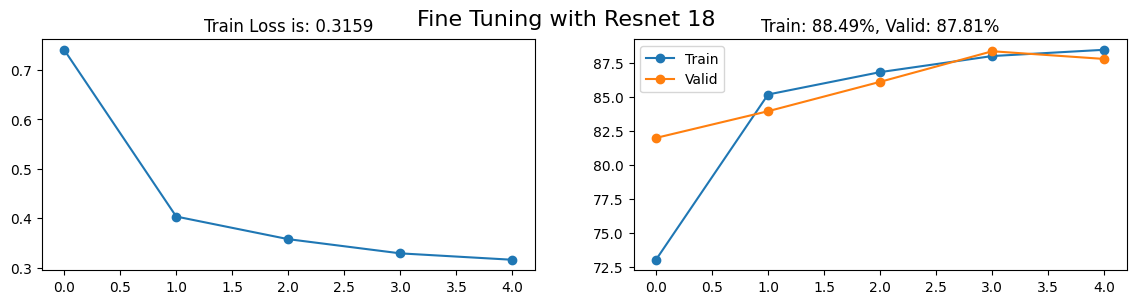

In [42]:
import matplotlib.pyplot as plt

final_loss = losses.mean(1)[-1]
final_train_acc = train_acc.mean(1)[-1]
final_valid_acc = valid_acc.mean(1)[-1]

fig, axs = plt.subplots(1, 2, figsize = (14, 3))

axs[0].plot(range(losses.shape[0]), losses.mean(1), "-o")
axs[0].set_title(f"Train Loss is: {final_loss:.4f}")


axs[1].plot(range(train_acc.shape[0]), train_acc.mean(1), "-o")
axs[1].plot(range(valid_acc.shape[0]), valid_acc.mean(1), "-o")
axs[1].set_title(f"Train: {final_train_acc:.2f}%, Valid: {final_valid_acc:.2f}%")
axs[1].legend(["Train", "Valid"])

plt.suptitle(f"Fine Tuning with Resnet 18", fontsize = 16)
plt.show()

In [43]:
x_test = test_dataset.data
y_test = test_dataset.targets

# Reshape and cast the input data
x_test = x_test.unsqueeze(1)
x_test = x_test.to(torch.float32)
x_test_norm = min_max_scale(x_test)

# Cast the target labels to the 'long' data type
y_test = y_test.to(torch.long)

test_loader = load_data(x_test_norm, y_test, batch_size=batch_size, test=True)

Total Mini-Batches: 79
Shape of Each Mini-Batch: torch.Size([128, 1, 28, 28])



In [44]:
test_acc = []
model.eval()
for i, (x, y) in enumerate(test_loader):
    out = model.forward(x.to(device))

    acc = 100 * (out.argmax(1) == y.to(device)).float().mean()
    test_acc.append(acc.cpu())
model.train()

print(f"Accuracy is: {np.mean(test_acc):.2f}%")

Accuracy is: 87.25%


## Save Model

In [45]:
# Save Model
from google.colab import drive
drive.mount('/content/drive')
model_path = '/content/drive/MyDrive/fnmnist_model.pth'
torch.save(model.state_dict(), model_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
# Load the model
model = models.resnet18(pretrained = False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 10)

model.load_state_dict(torch.load('/content/drive/MyDrive/fnmnist_model.pth',  map_location=torch.device('cpu')))

<All keys matched successfully>

In [47]:
test_acc = []
model.to(device)
model.eval()
for i, (x, y) in enumerate(test_loader):
    out = model.forward(x.to(device))

    acc = 100 * (out.argmax(1) == y.to(device)).float().mean()
    test_acc.append(acc.cpu())
model.train()

print(f"Accuracy is: {np.mean(test_acc):.2f}%")

Accuracy is: 87.25%


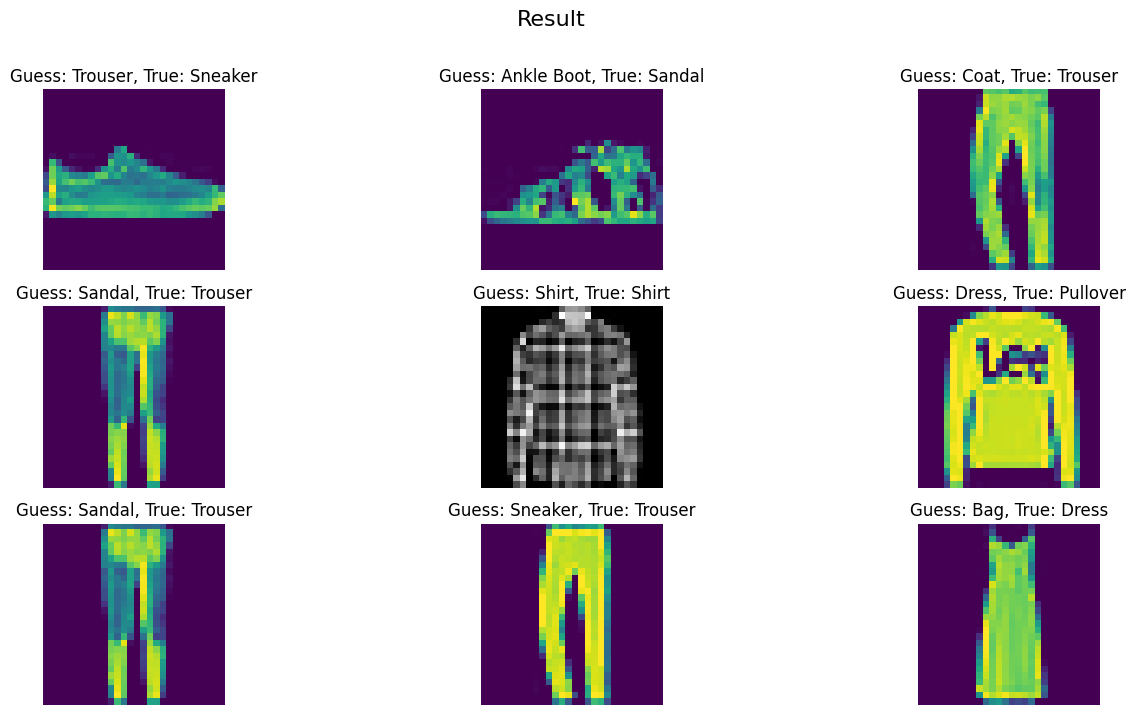

In [48]:
fig, axs = plt.subplots(3, 3, figsize=(16, 8))

for ax in axs.flatten():
    # Select a random index from the output
    random_index = np.random.choice(len(out))

    # Display the image at the selected index with colormap gray for correct predictions
    true_label = y_test[random_index]
    guess_label = out.argmax(1)[random_index]

    if true_label == guess_label:
        ax.imshow(x_test[random_index].view(28, 28), cmap="gray")
    else:
        ax.imshow(x_test[random_index].view(28, 28))


    ax.set_title(f"Guess: {classes[guess_label]}, True: {classes[true_label]}")
    ax.axis("off")

plt.suptitle("Result", fontsize=16)
plt.show()